#  Laboratorium z Podstaw Przetwarzania Sygnałów
## Laboratorium 5 - Dyskretna Transformata Kosinusowa i Fouriera

prowadzący: dr inż. Łukasz Jeleń  
  
Dzisiejsze zadania pochodzą z Allen B. Downey, Think DSP, Digital Signal Processing in Python, Green Tea Press, Wersja 1.0.5

Nazwisko i Imię: Foksińska Kinga  
Nr albumu: 255591  
data wykonania ćwiczenia: 06.12.2022  

w celu zachowania przeniesienia do kolejnej linii należy się upewnić, że na końcu linii znajduje się 2x spacja

## Zestaw narzędzi  

Na poprzednich zajęciach poznali Państwo narzędzia udostępnionne przez Autora podręcznika "Think DSP". W poniższej komórce macie Państo dane do ich pobrania - dla przypomnienia. 

In [1]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

--2022-12-25 13:22:27--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py [following]
--2022-12-25 13:22:27--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48687 (48K) [text/plain]
Saving to: ‘thinkdsp.py’

thinkdsp.py         100%[===================>]  47.55K  --.-KB/s    in 0.008s  

2022-12-25 13:22:27 (5.78 MB/s) - ‘thinkdsp.py’ saved [48687/48687]



In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate


#definicja liczby pi^2
import numpy as np
PI2 = np.pi * 2

## 1. Dyskretna Transformata Kosinusowa

Dyskretna transformata kosinusowa (DCT) jest bardzo często wykorzystywana w kompresji sygnałów, zarówno 1D (np.: mp3) jak i 2D (np.: jpeg, mpeg). Transformata ta jest w wilei aspektach bardzo zbliżona do dyskretnej transformaty Fouriera opisanej w kolejnym rozdziale.  
  
Zaczniemy od utworzenia (sytezy) fali.  
  
### Synteza  
  
Mając dany zbiór składowych częstotliwości oraz ich amplitudy utworzymy sygnał będący sumą tych komponentów. Najprostrzym przykładem będzie synteza sygnału jako suma sygnałów sinusoidalnych:

In [3]:
from thinkdsp import CosSignal, SumSignal

def synthesize1(amps, fs, ts):
    components = [CosSignal(freq, amp)
                  for amp, freq in zip(amps, fs)]
    signal = SumSignal(*components)

    ys = signal.evaluate(ts)
    return ys

przykład dla 4 komponentów:

In [4]:
from thinkdsp import Wave

amps = np.array([0.6, 0.25, 0.1, 0.05])
fs = [100, 200, 300, 400]
framerate = 11025

ts = np.linspace(0, 1, framerate, endpoint=False)
ys = synthesize1(amps, fs, ts)
wave = Wave(ys, ts, framerate)
wave.apodize()
wave.make_audio()

Proszę zauważyć, że wykorzystując numpy oraz właściwości mnożenia macierzy jestśmy w stanie wygenerować taki sam sygnał:

In [5]:
def synthesize2(amps, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    ys = np.dot(M, amps)
    return ys

In [6]:
ys = synthesize2(amps, fs, ts)
wave = Wave(ys, framerate)
wave.apodize()
wave.make_audio()

Jeżeli teraz wyznaczymy różnicę między sygnałami generowanymi za pomocą obu sposobów, zobaczymy, że jest ona stosunkowo niewielka. Potwierdza to nasze wcześniejsze stwierdzenie. 

In [7]:
ys1 = synthesize1(amps, fs, ts)
ys2 = synthesize2(amps, fs, ts)
np.max(np.abs(ys1 - ys2))

1.2789769243681803e-13

### Analiza sygnału  
  
Załóżmy teraz, że mamy sygnał składający się z sumy kosinusów o zadanych częstotliwościach. W jaki sposób moglibyśmy wyznaczyć amplitudę dla każdej składowej częstotliwości?  
  
#### Podejście analityczne  
  
Z algebry liniowej wiemy, że należy wyznaczyć $M=\cos(2\pi t \otimes f)$, co jest takie same jak w przypadku syntezy sygnałów. Następnie będziemy chcieli wyznaczyć $a$, takie że $y=Ma$. Mamy zatem do rozwiązania układ równań liniowych. Wykrzystamy do tego numpy. 

In [8]:
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

Zobaczmy, że dla 4 pierwszych wartości macierzy sygnału możemy wyznaczyć amplitudy:

In [9]:
n = len(fs)
amps2 = analyze1(ys[:n], fs, ts[:n])
amps2

array([0.6 , 0.25, 0.1 , 0.05])

Tak naprawdę, to wyznaczyliśmy sobie właśnie bardzo prostą wersję transformaty kosinusowej. Nalezy jednak zaznaczyć, że proponowane rozwiązanie nie jest optymalne, a złożoność obliczeniowa jest rzędu $O(n^3)$, gdzie $n$ jest ilością kolumn macierzy $M$. Głównym problemem jest fakt, że macierz ta nie jest ortogonalna.  
  
Najprostrzym sposobem rozwiązania układu liniowego jest wyznaczenie odwrotności macierzy ($M^{-1}$). W celu rozwiązania równania $y=Ma$ wystarczy, że pomnożymy obustronnie przez $M^{-1}$, co po uproszeczeniu da nam $M^{-1}y=a$. Wprawdzie zabieg ten nie za bardzo polepsza złożoność obliczeniową, ale jeśli weźmiemy pod uwagę przypadki specjalne, to już otrzymamy znaczne polepszenie czasu działania. W naszym przypadku stanie się tak jeśli macierz $M$ będzie ortogonalna, co oznacza, że $M^TM=I$. Zobaczmy zatem jak to działa.

In [10]:
# ustawienie precyzji do 3
np.set_printoptions(precision=3, suppress=True)

def test1():
    N = 4.0
    time_unit = 0.001
    ts = np.arange(N) / N * time_unit
    max_freq = N / time_unit / 2
    fs = np.arange(N) / N * max_freq
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    return M

M = test1()
M

array([[ 1.   ,  1.   ,  1.   ,  1.   ],
       [ 1.   ,  0.707,  0.   , -0.707],
       [ 1.   ,  0.   , -1.   , -0.   ],
       [ 1.   , -0.707, -0.   ,  0.707]])

In [11]:
M.transpose().dot(M)

array([[ 4.,  1., -0.,  1.],
       [ 1.,  2.,  1., -0.],
       [-0.,  1.,  2.,  1.],
       [ 1., -0.,  1.,  2.]])

Możemy zauważyć, że wyznaczona macierz nie jest ortogonalna. Poszukajmy zatem odpowiedniej macierzy, co pozwoli nam osiągnąć złożonośc rzędu $O(n^2)$, czyli znacznie lepiej. 

In [12]:
def test2():
    N = 4.0
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    return M
    
M = test2()
M

array([[ 0.981,  0.831,  0.556,  0.195],
       [ 0.831, -0.195, -0.981, -0.556],
       [ 0.556, -0.981,  0.195,  0.831],
       [ 0.195, -0.556,  0.831, -0.981]])

In [13]:
M.transpose().dot(M)

array([[ 2., -0.,  0.,  0.],
       [-0.,  2., -0., -0.],
       [ 0., -0.,  2., -0.],
       [ 0., -0., -0.,  2.]])

Zauważmy, że nasza macierz jest ortogonalna -> $2I$. Oznacza to, że możemy rozwiązać równanie uwzględniając to spostrzeżenie:

In [14]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = M.dot(ys) / 2
    return amps

In [15]:
n = len(fs)
amps2 = analyze1(ys[:n], fs, ts[:n])
amps2

array([0.6 , 0.25, 0.1 , 0.05])

Rozwiążmy teraz ten sam problem z wykorzystaniem transformaty kosinusowaej -> $DCT-IV$, która wykorzystuje macierze ortogonalne:

In [16]:
def dct_iv(ys):
    N = len(ys)
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

Z pliku `thinkdsp.py` możemy zastosować klasę `Dct`, która zawiera dyskretną transforamcję kosinusową, podobnie jak i transformatę Fouriera. Przykład:

In [17]:
from thinkdsp import TriangleSignal

signal = TriangleSignal(freq=400)
wave = signal.make_wave(duration=1.0, framerate=10000)
wave.make_audio()

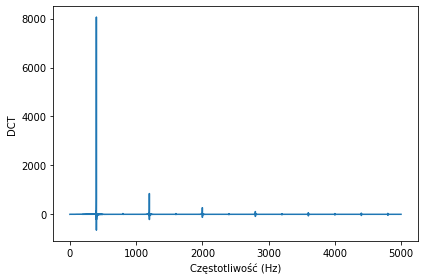

In [18]:
from thinkdsp import decorate

dct = wave.make_dct()
dct.plot()
decorate(xlabel='Częstotliwość (Hz)', ylabel='DCT')

w tej samej klasie znajdziemy metodę `make_wave()`, która jest implementacją odwrotnej DCT. 

In [19]:
wave2 = dct.make_wave()
np.max(np.abs(wave.ys-wave2.ys))

7.771561172376096e-16

Jeśli zanegujemy sygnał, to dokonamy zamiany znaku w DCT.

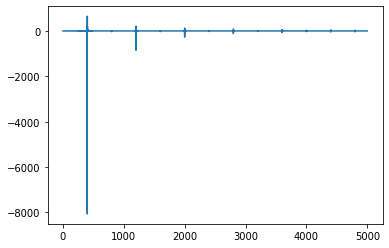

In [20]:
signal = TriangleSignal(freq=400, offset=0)
wave = signal.make_wave(duration=1.0, framerate=10000)
wave.ys *= -1
wave.make_dct().plot()

Co jest równoważne z dodaniem przesunięcia $\phi = \pi$

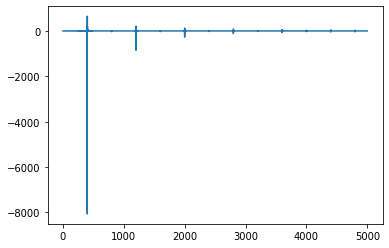

In [21]:
signal = TriangleSignal(freq=400, offset=np.pi)
wave = signal.make_wave(duration=1.0, framerate=10000)
wave.make_dct().plot()

## 2. Dyskretna Transformata Fouriera

Transformata Fouriera jest bardzo zbliżona do transformaty kosinusowej. Moglibyśmy nawet powiedzieć, że jedyną różnicą jest zastąpienie funkcji kosinusowej złożoną funkcją ekspotencjalną.  
  
Biorą powyższe pod uwagę, jeśli zdefiniujemy sygnał $\phi (t)$ jako funkcję czasu, to funkcja $e^{i\phi (t)}$ również będzie funkcją w czasie. A dokładniej: $e^{i\phi (t)} = \cos{\phi(t)} + i\sin{\phi(t)}$. W szczególnym przypadku, jeśli częstotliwość sygnału jest stała, $\phi (t)$ równa się $2\pi ft$, co skutkuje zdefiniowaniem złożonej sinusoidy: $e^{i2\pi ft} = \cos{2\pi ft}+i\sin{2\pi ft}$.  
  
W celu syntezy złożonej sinusoidy poostąpimy tak jak poprzednio, czyli będziemy dodawali sinusoidy o różnych częstotliwościach. Proces ten znowu mamy do czynienia z problemem: jak na podstawie danej częstotliwości i amplitudy dla każdej składowej dokonać ewaluacji sygnału? Zascznijmy od utworzenia takiej sinusoidy.

In [22]:
from thinkdsp import Sinusoid

class ComplexSinusoid(Sinusoid):
    """Represents a complex exponential signal."""
    
    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        print(ts)
        phases = PI2 * self.freq * ts + self.offset
        print(phases)
        ys = self.amp * np.exp(1j * phases)
        return ys

In [23]:
signal = ComplexSinusoid(freq=1, amp=0.6, offset=1)
wave = signal.make_wave(duration=1, framerate=4)
print(wave.ys)

[0.   0.25 0.5  0.75]
[1.    2.571 4.142 5.712]
[ 0.324+0.505j -0.505+0.324j -0.324-0.505j  0.505-0.324j]


Tak jak poprzednio, najprostrzym sposobem syntezy jest analiza sygnałów oraz ich zsumowanie. 

In [24]:
from thinkdsp import SumSignal

def synthesize1(amps, freqs, ts):
    components = [ComplexSinusoid(freq, amp)
                  for amp, freq in zip(amps, freqs)]
    signal = SumSignal(*components)
    ys = signal.evaluate(ts)
    return ys

Tak jak dla DCT wykorzystamy pierwsze 4 składowe oraz wyświtlimy wykres dla części rzeczywistej oraz urojonej sygnału. Dodatkowo sprawdzimy jak brzmią obie części. 

In [25]:
amps = np.array([0.6, 0.25, 0.1, 0.05])
freqs = [100, 200, 300, 400]
framerate = 11025

ts = np.linspace(0, 1, framerate, endpoint=False)
ys = synthesize1(amps, freqs, ts)
print(ys)

[0. 0. 0. ... 1. 1. 1.]
[  0.      0.057   0.114 ... 628.148 628.205 628.262]
[0. 0. 0. ... 1. 1. 1.]
[   0.       0.114    0.228 ... 1256.295 1256.409 1256.523]
[0. 0. 0. ... 1. 1. 1.]
[   0.       0.171    0.342 ... 1884.443 1884.614 1884.785]
[0. 0. 0. ... 1. 1. 1.]
[   0.       0.228    0.456 ... 2512.59  2512.818 2513.046]
[1.   +0.j    0.995+0.091j 0.979+0.18j  ... 0.953-0.267j 0.979-0.18j
 0.995-0.091j]


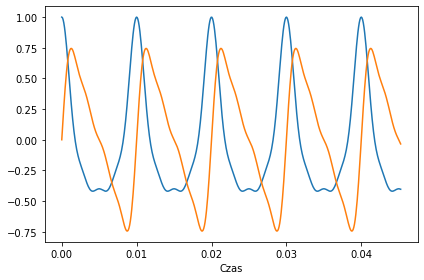

In [26]:
n = 500
plt.plot(ts[:n], ys[:n].real)
plt.plot(ts[:n], ys[:n].imag)
decorate(xlabel='Czas')

In [27]:
from thinkdsp import Wave

wave = Wave(ys.real, framerate)
wave.apodize()
wave.make_audio()

In [28]:
wave = Wave(ys.imag, framerate)
wave.apodize()
wave.make_audio()

Zauważyliśmy, że obie części brzmią tak samo. Dzieje się tak dlatego, że zarówno część rzeczywista (suma kosinusów) jak i część urojona (suma sinusów) posiadają takie same składowe częstotliwości o tych samych amplitudach. 

Powyższe możemy także osiągnąć przez mnożenie macierzy:

In [29]:
def synthesize2(amps, freqs, ts):
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    ys = np.dot(M, amps)
    return ys

In [30]:
amps = np.array([0.6, 0.25, 0.1, 0.05])
ys = synthesize2(amps, freqs, ts)
print(ys)

wave = Wave(ys.real, framerate)
wave.apodize()
wave.make_audio()

[1.   +0.j    0.995+0.091j 0.979+0.18j  ... 0.953-0.267j 0.979-0.18j
 0.995-0.091j]


W celu zaobserwowania efektu złożoności amplitudy obrócimy je o 1.5 radiana:

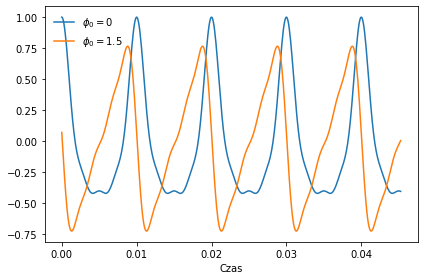

In [31]:
phi = 1.5
amps2 = amps * np.exp(1j * phi)
ys2 = synthesize2(amps2, freqs, ts)

n = 500
plt.plot(ts[:n], ys.real[:n], label=r'$\phi_0 = 0$')
plt.plot(ts[:n], ys2.real[:n], label=r'$\phi_0 = 1.5$')
decorate(xlabel='Czas')

Obrót wszystkich składowych o to samo przesunięcie fazowe zmienia kształt fali ponieważ składowe mają inny okres. Z tego powodu przesunięcie ma inny efekt dla poszczególnych składowych.  
  
#### Analiza  
  
Tak jak poprzednio dokonamy analizy sygnału (wyznaczenie amplitudy dla każdej składowej) poprzez stworzenie takiej samej macierzy jak ta wykorzystana do syntezy sygnału i rozwiąrzemy układ równań.

In [32]:
def analyze1(ys, freqs, ts):
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

Dla pierwszych 4 wartości:

In [33]:
n = len(freqs)
amps2 = analyze1(ys[:n], freqs, ts[:n])
print(amps2)

[0.6 -0.j 0.25+0.j 0.1 -0.j 0.05+0.j]


Jeśli teraz zdefiniujemy `freqs` w przedziale $0$ do $N-1$ oraz `ts` w przedziale $0$ do $\frac{N-1}{N}$, to otrzymamy macierz jednostkową.

In [34]:
N = 4
ts = np.arange(N) / N
freqs = np.arange(N)
args = np.outer(ts, freqs)
M = np.exp(1j * PI2 * args)
print(M)


MstarM = M.conj().transpose().dot(M)
print(MstarM.real)

[[ 1.+0.j  1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  0.+1.j -1.+0.j -0.-1.j]
 [ 1.+0.j -1.+0.j  1.-0.j -1.+0.j]
 [ 1.+0.j -0.-1.j -1.+0.j  0.+1.j]]
[[ 4. -0.  0.  0.]
 [-0.  4. -0.  0.]
 [ 0. -0.  4. -0.]
 [ 0.  0. -0.  4.]]


Sprawdzając, czy nasza macierz jest jednostkowa, wyznaczyliśmy $M*M$, co skutkowało otrzymaniem macierz $4I$ zamiast $I$> Możemy to wykorzystać i stworzyć szybszą wersję:

In [35]:
def analyze2(ys, freqs, ts):
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    amps = M.conj().transpose().dot(ys) / N
    return amps

In [36]:
N = 4
amps = np.array([0.6, 0.25, 0.1, 0.05])
freqs = np.arange(N)
ts = np.arange(N) / N
ys = synthesize2(amps, freqs, ts)

amps3 = analyze2(ys, freqs, ts)
print(amps3)

[0.6 +0.j 0.25+0.j 0.1 -0.j 0.05-0.j]


Pozwala nam to teraz zaproponować naszą wersję DFT:

In [37]:
def synthesis_matrix(N):
    ts = np.arange(N) / N
    freqs = np.arange(N)
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    return M
def dft(ys):
    N = len(ys)
    M = synthesis_matrix(N)
    amps = M.conj().transpose().dot(ys)
    return amps

i porównać z `analyze2`oraz FFT:

In [38]:
print(dft(ys))


print(np.fft.fft(ys))

[2.4+0.j 1. +0.j 0.4-0.j 0.2-0.j]
[2.4+0.j 1. -0.j 0.4-0.j 0.2-0.j]


Analogicznie jak dla DCT możemy zaproponować odwrotną transformatę Fouriera, ale tutaj nie musimy transponować macierzy $M$, ale musimy podzielić wartości przez $N$

In [39]:
def idft(amps):
    N = len(amps)
    M = synthesis_matrix(N)
    ys = M.dot(amps) / N
    return ys

In [40]:
ys = idft(amps)
print(dft(ys))

[0.6 +0.j 0.25+0.j 0.1 -0.j 0.05-0.j]


powyższe pokazuje, że jesteśmy w stanie wyznaczyć `amps`

## 3. Zadania

#### Zadanie 1  
  
Jedny z najczęstrzych zastsowań transformaty kosinusowej jest kompresja sygnałów, która jest wykonywana w 4 prostych krokach:  
  
1. Podziel sygnał na fragmenty
2. Wyznacz DCT dla każdego z fragemtnów
3. Określ i usuń składowe częstotliwości, które nie są słyszalne - o małych amplitudach. Pozostałe częstotliwości oraz amplitudy zapisz.
4. W celu odtworzenia sygnału, wczytaj częstotliwości oraz amplitudy dla każdego segmentu i wyznacz odwrotną DCT.  
  
Zaimplementuj powyższy algorytm i zastosuj go do nagrania muzycznego lub głosu. Odpowiedz na pytanie: Ile składowych można wyeliminować zanim różnica będzie słyszalna?  
  
Wskazówka: Do przechowania danych można zastosować jedną z implementacji NumPy: https://docs.scipy.org/doc/scipy/reference/sparse.html

In [156]:
import thinkdsp
import numpy as np
wave = read_wave("Freesound - acoustic guitar melody.wav")
wave.make_audio()

def nieslyszalne(dct, ograniczenie, zapis): 
  x = 0
  for j, amp in enumerate(dct.amps): #3. Określ i usuń składowe częstotliwości, które nie są słyszalne - o małych amplitudach
    if np.abs(amp) < ograniczenie:
      dct.hs[j] = 0
      x = x+1
    else:
      zapis.append([dct.fs[j], dct.hs[j]]) #3. Pozostałe częstotliwości oraz amplitudy zapisz.

i=0.0
zapis = []
list_waves = []
while i< wave.duration: #1. Podziel sygnał na fragmenty
  segment = wave.segment(start = (0.0 + i), duration = 0.2)
  segment.normalize() 
  i = i + 0.2
  dct = segment.make_dct() #2. Wyznacz DCT dla każdego z fragemtnów
  nieslyszalne(dct, 10, zapis)
  seg = dct.make_wave() #4. Wyznacz odwrotną DCT
  list_waves.append(seg)

for items in list_waves: items.make_audio()

**Odp**.: Po sprawdzeniu różnych wartości ograniczenia w funkcji nieslyszalne, która odpowiada za usunięcie częstotliwości o amplitudach mniejszych od zadanego ograniczenia zauważamy, że przy eliminacji do 5% składowych nie możemy usłyszeć różnicy w dźwięku. Przy usunięciu od 5 do 15% składowych w części segmentów możemy usłyszeć różnicę. Jednak dopiero przy usunięciu 20% lub więcej różnica ta jest mocno słyszalna.

#### Zadanie 2  
  
Prezentowane wcześniej implementacje pozwalały wyznaczyć DFT ze złożonością obliczeniową rzędu  $O(N^3)$ oraz $O(N^2)$, gdzie $N$ jest długością fali. Bardzo często korzysta się jednak lematu Danielsona-Lanczosa, który pozwala na osiągnięcie złożoności rzędu $Nlog N$. Lemat zakłada podejście rekurencyjne:  
  
1. Mając daną tablicę z falą, $y$, podziel ją na części parzyste, $e$ oraz nieparzyste $o$
2. Wyznacz recurencyjnie DFT dla $e$ i $o$. 
3. Wyznacz $DFT(y)$ dla każdej wartości $n$ z wykorzystaniem lematu Danielsona-Lanczosa: $DFT(y)[n] = DFT(e)[n] + \exp(-2\pi in/N)DFT(o)[n]$, gdzie $DFT(y)[n]$ jest n-tym elementem DFT dla y.   
  
Jako warunek podstawowy rekurencji można wykorzystać długość $y=1$, co w tymprzypadku będzie $DFT(y)=y$. Można też, dla $y$ wystarczająco małego, wyznaczyć DFT przez mnożenie macierzy.  
  
Więcej na temat FFT: https://pl.wikipedia.org/wiki/Szybka_transformacja_Fouriera  
  
Zadaniem jest zaimplementowanie powyższego podejścia.

In [175]:
def fft(y):
  l = len(y)
  
  #warunek podstawowy rekurencji:   
  if l == 1:
    return y
  
  #1. Mając daną tablicę z falą  y , podziel ją na części parzyste  e  oraz nieparzyste  o
  e = y[::2]
  o = y[1::2]

  #2. Wyznacz rekurencyjnie DFT dla  e  i  o .
  fft1 = fft(e)
  fft2 = fft(o)

  #3. Wyznacz  DFT(y)  dla każdej wartości  n  z wykorzystaniem lematu Danielsona-Lanczosa
  n = np.arange(l)
  W = np.exp(-1j * PI2 * n / l)
    
  return np.tile(fft1, 2) + W * np.tile(fft2, 2)